## (Ungraded) ~~Keras~~ PyTorch Tutorial | Week 2
### Emotion Detection in Images of Faces

### 1 - Emotion Tracking

* A nearby community health clinic is helping the local residents monitor their mental health.  
* As part of their study, they are asking volunteers to record their emotions throughout the day.
* To help the participants more easily track their emotions, you are asked to create an app that will classify their emotions based on some pictures that the volunteers will take of their facial expressions.
* As a proof-of-concept, you first train your model to detect if someone's emotion is classified as "happy" or "not happy."

To build and train this model, you have gathered pictures of some volunteers in a nearby neighborhood. The dataset is labeled.
<img src="Images/face_images.png" style="width:550px;height:250px;">


In [1]:
# lib import
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

%matplotlib inline

In [13]:
# helper function to get data
def get_data():
    train_data = h5py.File('Data - Keras Tutorial/train_happy.h5', 'r')
    test_data = h5py.File('Data - Keras Tutorial/test_happy.h5', 'r')
    train_imgs = np.array(train_data['train_set_x'][:]).transpose((0,3,1,2))
    train_lbls = np.array(train_data['train_set_y'][:])
    test_imgs = np.array(test_data['test_set_x'][:]).transpose((0,3,1,2))
    test_lbls = np.array(test_data['test_set_y'][:])
    classes = np.array(test_data['list_classes'][:])
    X_train, X_test = train_imgs/255, test_imgs/255
    Y_train, Y_test = train_lbls.reshape((train_lbls.shape[0], 1)), test_lbls.reshape((test_lbls.shape[0], 1))
    
    return X_train, Y_train, X_test, Y_test, classes

In [14]:
X_train_np, Y_train_np, X_test_np, Y_test_np, classes = get_data()

print("No. of training examples = " + str(X_train_np.shape[0]))
print("No. of test examples = " + str(X_test_np.shape[0]))
print("X_train shape: " + str(X_train_np.shape)) # (N, C, H, W)
print("Y_train shape: " + str(Y_train_np.shape)) # (N, C, H, W)
print("X_test shape: " + str(X_test_np.shape))
print("Y_test shape: " + str(Y_test_np.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 3, 64, 64)
Y_train shape: (600, 1)
X_test shape: (150, 3, 64, 64)
Y_test shape: (150, 1)


### See (?) data 

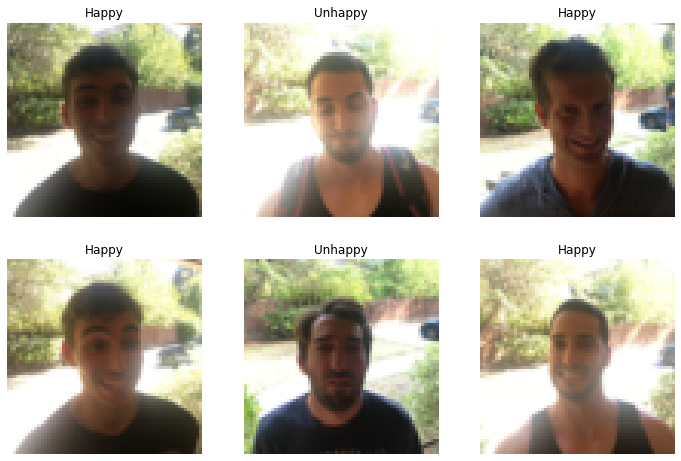

In [20]:
train_data = h5py.File('Data - Keras Tutorial/train_happy.h5', 'r')
imgs = np.array(train_data['train_set_x'][:])
lbls = np.array(train_data['train_set_y'][:])

def vis_n_imgs(n, images, labels):
    a = np.sqrt(n)
    if not float.is_integer(a):a += 1
    a = int(a)
    fig, axs = plt.subplots(nrows=a, ncols=a, figsize=(10, 10))
    random_indexes = np.random.randint(0, images.shape[0], size=n)
    fig.tight_layout()
    for ax_idx, img_idx in enumerate(random_indexes):
        ax = axs.flat[ax_idx]
        ax.imshow(images[img_idx])
        ax.set_axis_off()
        label = 'Happy' if labels[img_idx] == 1 else 'Unhappy'
        ax.set_title(label)
        
    for i in range(n, a*a):
        ax = axs.flat[i]
        ax.remove()
        
vis_n_imgs(6, imgs, lbls)

### pack data into TensorDatasets and Dataloaders

In [27]:
def pack4training(X_train, Y_train, X_test, Y_test):
    # convert np arrays into torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float)
    
    train_dl = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=32, shuffle=True)
    test_dl = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=32, shuffle=True)
    
    return train_dl, test_dl

X_train_np, Y_train_np, X_test_np, Y_test_np, classes = get_data()
train_dl, test_dl = pack4training(X_train_np, Y_train_np, X_test_np, Y_test_np)

### Model

In [82]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nn.Sequential(
    # inp_channels = 3 | output_channels = 32
    nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3), # same conv: dims same
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # reduce dims to half H, W
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # same conv again
    nn.BatchNorm2d(32),
    nn.ReLU(),
    Flatten(),
    nn.Linear(32768, 1)
).to(device)

loss_func_1 = nn.BCEWithLogitsLoss()
loss_func_2 = nn.MSELoss()
opt1 = optim.Adam(model.parameters(), lr=1e-3)
opt2 = optim.SGD(model.parameters(), lr=1e-3)

In [64]:
def accuracy(model, loader):
    model.eval()
    total_items = 0
    total_correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            total_items += x.size(0)
            y_pred = torch.sigmoid(model(x))
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            total_correct += (y_pred == y).sum().item()
    return total_correct / total_items

In [65]:
def train(model, train_dl, test_dl, opt, loss_func, epochs=1):
    model.train()
    itr = 1
    for epoch in range(epochs):
        for _, (x, y) in enumerate(train_dl):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            opt.zero_grad()
            loss = loss_func(y_pred.view(-1), y.view(-1))
            loss.backward()
            opt.step()
            if itr%50==0:print('Loss rn: ', loss.item())
            itr+=1
        test_acc = accuracy(model, test_dl)
        train_acc = accuracy(model, train_dl)
        print('Epoch: {} | Train Accuracy: {} | Test Accuracy: {}'.format(epoch, train_acc, test_acc))

Type 1

## Testing for Model 1
**Architecture**
```py
nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3), # same conv: dims same
nn.BatchNorm2d(16),
nn.ReLU(),
nn.MaxPool2d(kernel_size=2, stride=2), # reduce dims to half H, W
nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # same conv again
nn.BatchNorm2d(32),
nn.ReLU(),
Flatten(),
nn.Linear(32768, 1)
```

In [71]:
# ADAM with lr 1e-3 | Model 1
train(model, train_dl, test_dl, opt1, loss_func_1, epochs=20)

Epoch: 0 | Train Accuracy: 0.74 | Test Accuracy: 0.72
Epoch: 1 | Train Accuracy: 0.86 | Test Accuracy: 0.8266666666666667
Loss rn:  0.27943891286849976
Epoch: 2 | Train Accuracy: 0.92 | Test Accuracy: 0.9133333333333333
Epoch: 3 | Train Accuracy: 0.9666666666666667 | Test Accuracy: 0.9066666666666666
Epoch: 4 | Train Accuracy: 0.9566666666666667 | Test Accuracy: 0.94
Loss rn:  0.10901781171560287
Epoch: 5 | Train Accuracy: 0.9516666666666667 | Test Accuracy: 0.92
Epoch: 6 | Train Accuracy: 0.97 | Test Accuracy: 0.96
Loss rn:  0.1684102714061737
Epoch: 7 | Train Accuracy: 0.97 | Test Accuracy: 0.92
Epoch: 8 | Train Accuracy: 0.9666666666666667 | Test Accuracy: 0.96
Epoch: 9 | Train Accuracy: 0.975 | Test Accuracy: 0.9533333333333334
Loss rn:  0.018149061128497124
Epoch: 10 | Train Accuracy: 0.96 | Test Accuracy: 0.9133333333333333
Epoch: 11 | Train Accuracy: 0.985 | Test Accuracy: 0.9533333333333334
Epoch: 12 | Train Accuracy: 0.9883333333333333 | Test Accuracy: 0.9533333333333334
Loss 

In [72]:
# SGD with lr 1e-3 | Model 1
train(model, train_dl, test_dl, opt2, loss_func_1, epochs=20)

Epoch: 0 | Train Accuracy: 0.9866666666666667 | Test Accuracy: 0.9533333333333334
Epoch: 1 | Train Accuracy: 0.9883333333333333 | Test Accuracy: 0.9533333333333334
Loss rn:  0.004239029251039028
Epoch: 2 | Train Accuracy: 0.9866666666666667 | Test Accuracy: 0.94
Epoch: 3 | Train Accuracy: 0.9883333333333333 | Test Accuracy: 0.94
Epoch: 4 | Train Accuracy: 0.9866666666666667 | Test Accuracy: 0.94
Loss rn:  0.0707486942410469
Epoch: 5 | Train Accuracy: 0.9866666666666667 | Test Accuracy: 0.94
Epoch: 6 | Train Accuracy: 0.9883333333333333 | Test Accuracy: 0.96
Loss rn:  0.003700900124385953
Epoch: 7 | Train Accuracy: 0.9883333333333333 | Test Accuracy: 0.9466666666666667
Epoch: 8 | Train Accuracy: 0.99 | Test Accuracy: 0.94
Epoch: 9 | Train Accuracy: 0.9883333333333333 | Test Accuracy: 0.94
Loss rn:  0.01228456012904644
Epoch: 10 | Train Accuracy: 0.9883333333333333 | Test Accuracy: 0.94
Epoch: 11 | Train Accuracy: 0.99 | Test Accuracy: 0.94
Epoch: 12 | Train Accuracy: 0.99 | Test Accurac

In [79]:
# ADAM only MSE loss | Model 1
train(model, train_dl, test_dl, opt1, loss_func_2, epochs=20)

Epoch: 0 | Train Accuracy: 0.5033333333333333 | Test Accuracy: 0.54
Epoch: 1 | Train Accuracy: 0.49833333333333335 | Test Accuracy: 0.56
Loss rn:  0.20680105686187744
Epoch: 2 | Train Accuracy: 0.5 | Test Accuracy: 0.56
Epoch: 3 | Train Accuracy: 0.5 | Test Accuracy: 0.56
Epoch: 4 | Train Accuracy: 0.515 | Test Accuracy: 0.5666666666666667
Loss rn:  0.17290569841861725
Epoch: 5 | Train Accuracy: 0.56 | Test Accuracy: 0.5866666666666667
Epoch: 6 | Train Accuracy: 0.535 | Test Accuracy: 0.58
Loss rn:  0.1259564608335495
Epoch: 7 | Train Accuracy: 0.5083333333333333 | Test Accuracy: 0.56
Epoch: 8 | Train Accuracy: 0.5416666666666666 | Test Accuracy: 0.5933333333333334
Epoch: 9 | Train Accuracy: 0.515 | Test Accuracy: 0.5733333333333334
Loss rn:  0.034395888447761536
Epoch: 10 | Train Accuracy: 0.53 | Test Accuracy: 0.5933333333333334
Epoch: 11 | Train Accuracy: 0.7033333333333334 | Test Accuracy: 0.6866666666666666
Epoch: 12 | Train Accuracy: 0.785 | Test Accuracy: 0.76
Loss rn:  0.050424

In [81]:
# SGD with MSE Loss | Model 1
train(model, train_dl, test_dl, opt2, loss_func_2, epochs=20)

Epoch: 0 | Train Accuracy: 0.49833333333333335 | Test Accuracy: 0.56
Epoch: 1 | Train Accuracy: 0.49166666666666664 | Test Accuracy: 0.56
Loss rn:  0.2955773174762726
Epoch: 2 | Train Accuracy: 0.49 | Test Accuracy: 0.56
Epoch: 3 | Train Accuracy: 0.49 | Test Accuracy: 0.56
Epoch: 4 | Train Accuracy: 0.49166666666666664 | Test Accuracy: 0.56
Loss rn:  0.2671756148338318
Epoch: 5 | Train Accuracy: 0.49166666666666664 | Test Accuracy: 0.56
Epoch: 6 | Train Accuracy: 0.49166666666666664 | Test Accuracy: 0.56
Loss rn:  0.3653299808502197
Epoch: 7 | Train Accuracy: 0.49833333333333335 | Test Accuracy: 0.56
Epoch: 8 | Train Accuracy: 0.49833333333333335 | Test Accuracy: 0.56
Epoch: 9 | Train Accuracy: 0.5 | Test Accuracy: 0.56
Loss rn:  0.2886154353618622
Epoch: 10 | Train Accuracy: 0.49833333333333335 | Test Accuracy: 0.56
Epoch: 11 | Train Accuracy: 0.5 | Test Accuracy: 0.56
Epoch: 12 | Train Accuracy: 0.5 | Test Accuracy: 0.56
Loss rn:  0.30122295022010803
Epoch: 13 | Train Accuracy: 0.5 

## Result
| Condition (Model: Conv-->MaxPool-->Conv-->FC ) | Train Accuracy | Test Accuracy |
|------------------------------------------------|----------------|---------------|
| ADAM \| 1e-3 \| 20 epochs \| BCEWithLogits     | 99.16          | 94.66         |
| SGD \| 1e-2 \| 20 epochs \| BCEWithLogits      | 99             | 95.33         |
| ADAM \| 1e-3 \| 20 epochs \| MSE               | 52.83          | 58.67         |
| SGD \| 1e-3 \| 20 epochs \| MSE                | 50             | 56            |

### Testing on Real Data

Unhappy


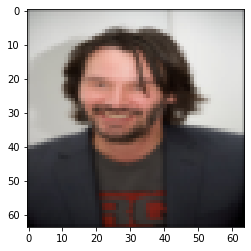

In [100]:
def predict(model, image_tensor):
    model.eval()
    y_pred = torch.sigmoid(model(image_tensor))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    return y_pred
from skimage.transform import resize
fname = "Images/keanu_smile.jpg"
image = np.array(plt.imread(fname))
my_image = resize(image, (64,64), mode='constant')
plt.imshow(my_image)
image_tensor = torch.tensor(my_image.transpose(2, 0, 1), dtype=torch.float).to(device)
y_pred = predict(model, image_tensor.view(1, 3, 64, 64))
if y_pred.item() == 1:
    print('Happy')
else:
    print('Unhappy')
    

Oof, that didn't turn as expected.

sad FIN.